# Starting machine learning

In [1]:
import pandas as pd
df = pd.read_csv(r'./TempFiles/RealEstate_PARIS_FR_2022.csv')

In [2]:
df.head()

,Nature mutation,Valeur fonciere,Type local,Nombre pieces principales,Surface,Latitude,Longitude
0,Vente,580000.0,Appartement,2,61.00,48.884552,2.348164
1,Vente,605000.0,Appartement,3,40.66,48.863303,2.362994
2,Vente,716250.0,Appartement,3,66.26,48.880446,2.332356
3,Vente,320000.0,Appartement,2,35.19,48.879574,2.362449
4,Vente,320000.0,Appartement,1,32.52,48.873304,2.405160


In [3]:
target_column = 'Valeur fonciere'
X = df.drop(columns=target_column, axis=1)
Y = df.loc[:,target_column]

In [4]:
df.dtypes

Nature mutation               object
Valeur fonciere              float64
Type local                    object
Nombre pieces principales      int64
Surface                      float64
Latitude                     float64
Longitude                    float64
dtype: object

In [5]:
categorical_features=pd.Index(['Nature mutation', 'Type local'], dtype='object')
numeric_features = pd.Index(['Nombre pieces principales', 'Surface', 'Latitude', 'Longitude'], dtype='object')

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
# numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())])
numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", MinMaxScaler())])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), 
                                          ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))])
preprocessor = ColumnTransformer(sparse_threshold=0, 
    transformers=[
       ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ])

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [7]:
X_train

,Nature mutation,Type local,Nombre pieces principales,Surface,Latitude,Longitude
13039,Vente,Appartement,1,28.74,48.838425,2.294053
4115,Vente,Appartement,2,48.47,48.878919,2.384198
4919,Vente,Appartement,1,27.62,48.863487,2.353488
7436,Vente,Appartement,4,68.53,48.893083,2.328137
5131,Vente,Appartement,3,38.00,48.887383,2.323559
...,...,...,...,...,...,...
9225,Vente,Appartement,1,24.12,48.848365,2.319469
13123,Vente,Appartement,3,63.58,48.857102,2.302125
9845,Vente,Appartement,4,87.92,48.854315,2.338195
10799,Vente,Appartement,3,43.92,48.844700,2.354617


In [8]:
X_train = preprocessor.fit_transform(X_train)
X_train = pd.DataFrame(X_train,columns=preprocessor.get_feature_names_out())
X_test = preprocessor.transform(X_test)

In [9]:
# Displaying transformed data before training !
X_train

,num__Nombre pieces principales,num__Surface,num__Latitude,num__Longitude,cat__Nature mutation_Vente en l'état futur d'achèvement
0,0.000000,0.108784,0.976554,0.259180,0.0
1,0.166667,0.186157,0.992222,0.266809,0.0
2,0.000000,0.104392,0.986251,0.264210,0.0
3,0.500000,0.264824,0.997702,0.262064,0.0
4,0.333333,0.145098,0.995497,0.261677,0.0
...,...,...,...,...,...
14385,0.000000,0.090667,0.980400,0.261331,0.0
14386,0.333333,0.245412,0.983780,0.259863,0.0
14387,0.500000,0.340863,0.982702,0.262916,0.0
14388,0.333333,0.168314,0.978982,0.264305,0.0


In [10]:
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import r2_score

In [11]:
regressor = XGBRegressor(n_jobs=-1)
regressor.fit(X_train, Y_train)
Y_train_pred = regressor.predict(X_train)
Y_test_pred = regressor.predict(X_test)
print("R² score on train set : ", r2_score(Y_train, Y_train_pred))
print("R² score on test set : ", r2_score(Y_test, Y_test_pred))

R² score on train set :  0.9865014508974751
R² score on test set :  0.9591686376553857


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

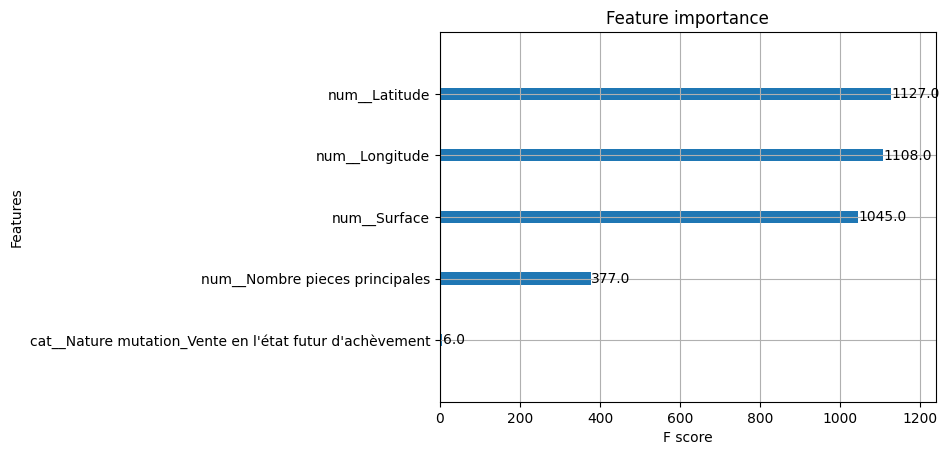

In [12]:
import xgboost
xgboost.plot_importance(regressor)

# Saving model and preprocessor to be used by streamlit app to predict values

In [13]:
regressor.save_model('./ModelFiles/RealEstate_PARIS_FR_2022.xgbmodel')

In [14]:
from pickle import dump
dump(preprocessor, open('./ModelFiles/preprocessor.dmp', 'wb'))